# Data Engineering Pipeline: OpenSky Network Data Ingest
Dieses Notebook konsolidiert den ETL-Prozess (Extract, Transform, Load) für Flugdaten.

**Ablauf:**
1.  **Konfiguration:** Zentrale Steuerung von Pfaden und S3-Parametern.
2.  **Aircraft Ingest (Pandas):** Download der Flugzeug-Stammdaten (CSV) und Konvertierung nach Parquet.
3.  **Flight Data Ingest (Spark):** Skalierbarer Download und Transformation von Flugbewegungsdaten aus S3.
4.  **Daten-Validierung:** Überprüfung der erzeugten Parquet-Dateien und Metriken.

**Autorenhinweis:**
Alle Ausgabadaten (Parquet, JSON, CSV) landen in dem unter `CONFIG` definierten Verzeichnis.

In [6]:
# 1. STANDARD-LIBRARIES (In Python enthalten)
import csv
import gzip
import io
import json
import logging
import os
import sys
import tarfile
import threading
import time
from datetime import datetime
from io import BytesIO
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 2. THIRD-PARTY LIBRARIES (Müssen meist via pip installiert sein)

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import requests
from botocore import UNSIGNED
from botocore.config import Config as BotoConfig
from dotenv import load_dotenv

# 3. PYSPARK (Big Data Framework)
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

print("✅ Alle Bibliotheken erfolgreich geladen.")

✅ Alle Bibliotheken erfolgreich geladen.


# 1. Zentrale Konfiguration & Steuerung

In dieser Sektion werden alle Parameter der Pipeline zentral definiert.
**Wichtig:** Es landen alle Dateien in einem definierbaren Wurzelverzeichnis (`DATA_ROOT_DIR`).

**Einstellbare Parameter:**
* **Speicherort (`DATA_ROOT_DIR`):** Der absolute oder relative Pfad, in dem *alle* Projektdaten abgelegt werden.
* **Datenmenge (`FLIGHT_DATA_LIMIT`):** Steuert die Anzahl der zu ladenden Dateien (für Benchmarks oder Voll-Ingest).
* **Zeitraum-Filter:** Ermöglicht das gezielte Laden bestimmter Jahre, Monate oder Tage (z.B. nur "2022"). Setzen Sie Werte auf `None`, um den Filter zu deaktivieren.
* **S3 & Dateinamen:** Konfiguration der Endpunkte und Dateinamen für Inputs/Outputs.

In [7]:
# KONFIGURATION (Muss vor allem anderen kommen)
class PipelineConfig:
    # 1. HAUPT-SPEICHERORT
    DATA_ROOT_DIR = os.path.join(os.getcwd(), "project_data_output")

    # 2. STEUERUNG
    FLIGHT_DATA_LIMIT = 50  # Limit für Benchmark

    # 3. AUTOMATISCHE PFADE
    RAW_DIR = os.path.join(DATA_ROOT_DIR, "raw")
    PROCESSED_DIR = os.path.join(DATA_ROOT_DIR, "processed")
    METRICS_DIR = os.path.join(DATA_ROOT_DIR, "metrics")
    METRICS_FILE = os.path.join(METRICS_DIR, "pipeline_metrics.json")

    # S3 Settings
    S3_BUCKET = os.getenv("BUCKET_NAME", "data-samples")
    S3_ENDPOINT = os.getenv("S3_ENDPOINT", "https://s3.opensky-network.org")

# Ordner erstellen
def init_directories():
    for path in [PipelineConfig.DATA_ROOT_DIR, PipelineConfig.RAW_DIR, PipelineConfig.PROCESSED_DIR, PipelineConfig.METRICS_DIR]:
        os.makedirs(path, exist_ok=True)

init_directories()



# 1. WINDOWS ENVIRONMENT FIX (Pflicht für Java/Hadoop)
import os
import sys
import pyspark

# DEINE PFADE (angepasst)
JAVA_HOME_PATH = r"C:\ProgramData\jdk-11.0.29.7-hotspot"
HADOOP_HOME_PATH = r"C:\hadoop"
PYTHON_PATH = sys.executable

# Environment setzen
os.environ['JAVA_HOME'] = JAVA_HOME_PATH
os.environ['HADOOP_HOME'] = HADOOP_HOME_PATH
os.environ['PYSPARK_PYTHON'] = PYTHON_PATH
os.environ['PYSPARK_DRIVER_PYTHON'] = PYTHON_PATH

# Spark Home finden
spark_home_candidate = os.path.dirname(pyspark.__file__)
if os.path.exists(os.path.join(spark_home_candidate, "bin")):
    os.environ['SPARK_HOME'] = spark_home_candidate

# PATH Update
new_path = (
        os.path.join(JAVA_HOME_PATH, "bin") + os.pathsep +
        os.path.join(HADOOP_HOME_PATH, "bin") + os.pathsep +
        os.path.join(os.environ.get('SPARK_HOME', ''), "bin") + os.pathsep +
        os.environ.get('PATH', '')
)
os.environ['PATH'] = new_path

# 2. SPARK SESSION INITIALISIERUNG
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

print("⏳ Starte Spark Session...")

# Konfiguration
conf = SparkConf() \
    .setAppName("OpenSkyIngest") \
    .setMaster("local[*]") \
    .set("spark.sql.shuffle.partitions", "20") \
    .set("spark.driver.memory", "2g") \
    .set("spark.driver.host", "localhost")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()

print(f"🏆 Spark läuft. Version: {spark.version}")

⏳ Starte Spark Session...
🏆 Spark läuft. Version: 3.5.0


## 2. Aircraft Database Ingest (Stammdaten)

**Hinweis:** Dies ist **nicht** der Haupt-Download der Flugbewegungen (diese folgen in Schritt 3 mittels Spark).

In diesem Schritt laden wir lediglich eine **Referenz-Tabelle** (Lookup-Table) herunter, die Flugzeug-Kennungen (`icao24`) mit Metadaten wie **Hersteller, Modell und Airline** verknüpft.
* **Zweck:** Diese Daten werden später im Use Case benötigt, um die rohen Flugdaten anzureichern (Data Enrichment), z. B. um zu analysieren, welcher Hersteller am häufigsten fliegt.
* **Technologie:** Da dieser Datensatz vergleichsweise klein ist (einige hundert MB), nutzen wir hier **Pandas** statt Spark für eine einfache In-Memory-Verarbeitung.
* **Output:** Das Ergebnis wird als optimierte Parquet-Datei (`aircraft_database.parquet`) im `processed`-Ordner gespeichert.

In [8]:
def ingest_aircraft_database(config):
    # Import & Setup für den Logger direkt hier
    # Logger initialisieren (falls noch nicht geschehen)
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger("Pipeline")

    logger.info("--- Start: Aircraft Database Ingest (Metadata) ---")

    # Client erstellen
    s3 = boto3.client('s3', endpoint_url=config.S3_ENDPOINT, config=BotoConfig(signature_version=UNSIGNED))

    # Suchen der Datei (Root oder metadata Ordner)
    possible_keys = [f"metadata/{config.AIRCRAFT_CSV_NAME}", config.AIRCRAFT_CSV_NAME]
    found_key = None

    for key in possible_keys:
        try:
            # Check ob Datei existiert (Head Request spart Traffic)
            s3.head_object(Bucket=config.S3_BUCKET, Key=key)
            found_key = key
            break
        except:
            continue

    if not found_key:
        logger.warning(f"Aircraft Datei {config.AIRCRAFT_CSV_NAME} nicht gefunden.")
        return None

    try:
        logger.info(f"Lade Metadaten herunter: {found_key}")
        obj = s3.get_object(Bucket=config.S3_BUCKET, Key=found_key)

        # Lesen (Aircraft DB kann 'bad lines' enthalten, daher on_bad_lines='skip')
        df = pd.read_csv(obj['Body'], dtype=str, quotechar="'", on_bad_lines='skip')

        # Filtern & Speichern
        # Wir behalten nur relevante Spalten für den Use Case
        cols = ['icao24', 'manufacturerName', 'model', 'typecode', 'operator']
        df = df[[c for c in cols if c in df.columns]].drop_duplicates(subset=['icao24'])

        out_path = os.path.join(config.PROCESSED_DIR, config.AIRCRAFT_PARQUET_NAME)
        df.to_parquet(out_path, index=False)

        logger.info(f"✅ Aircraft Reference-Data als Parquet erstellt: {out_path}")
        return out_path

    except Exception as e:
        logger.error(f"Fehler bei Aircraft Ingest: {e}")
        return None

## 3. Flight Data Ingest & Performance Monitoring (Spark Core)

Dies ist das Herzstück der Pipeline. Hier werden die massenhaften Flugbewegungsdaten von S3 geladen und verarbeitet.

**Wichtige Architektur-Entscheidungen:**
1.  **Streaming statt Bulk-Load:** Um "Out of Memory" (OOM) Fehler zu vermeiden, werden Dateien nicht mehr komplett in den RAM geladen. Stattdessen streamen wir den S3-Response direkt in den `gzip`-Dekompressor. Das hält den Speicherverbrauch konstant niedrig ($O(1)$), egal wie groß die Datei ist.
2.  **Performance Monitor:** Eine eigens implementierte Klasse überwacht während des Ingests **CPU, RAM, Netzwerk-Traffic und Disk-I/O** in einem separaten Thread. Dies liefert die Datenbasis für die spätere Skalierbarkeits-Analyse.
3.  **Spark Parallelisierung:** Die Liste der zu ladenden S3-Keys wird in ein RDD umgewandelt und auf die Worker verteilt (`repartition`), sodass der Download parallel stattfindet.

**Funktionsweise:**
* Die Klasse `PerformanceMonitor` startet einen Hintergrund-Thread zur Messung der Systemressourcen.
* Die Funktion `ingest_flight_data_spark` orchestriert den Download. Sie ist "Throttling-Aware" und liest Daten effizient, um externe API-Limits nicht unnötig zu reizen.

In [9]:
# 1. PERFORMANCE MONITOR KLASSE (Robust & mit Disk I/O)
class PerformanceMonitor:
    def __init__(self):
        self.running = False
        self.cpu_usage = []
        self.ram_usage = []
        self.net_recv = []
        self.disk_write = []  # NEU: Disk Write
        self.start_time = 0
        self._thread = None

    def _monitor_loop(self):
        # Initial-Werte (Offset) für Differenzmessung
        try:
            net_start = psutil.net_io_counters()
            start_recv = net_start.bytes_recv

            disk_start = psutil.disk_io_counters()
            start_write = disk_start.write_bytes
        except:
            start_recv = 0
            start_write = 0

        while self.running:
            # CPU & RAM
            self.cpu_usage.append(psutil.cpu_percent(interval=None))
            self.ram_usage.append(psutil.virtual_memory().percent)

            # Netzwerk (Download in MB)
            try:
                curr_recv = psutil.net_io_counters().bytes_recv
                self.net_recv.append((curr_recv - start_recv) / (1024 * 1024))
            except:
                self.net_recv.append(0)

            # Disk (Write in MB)
            try:
                curr_write = psutil.disk_io_counters().write_bytes
                self.disk_write.append((curr_write - start_write) / (1024 * 1024))
            except:
                self.disk_write.append(0)

            time.sleep(1)

    def start(self):
        self.running = True
        self.start_time = time.time()
        self.cpu_usage, self.ram_usage, self.net_recv, self.disk_write = [], [], [], []
        psutil.cpu_percent(interval=None)  # Init call
        self._thread = threading.Thread(target=self._monitor_loop)
        self._thread.start()

    def stop(self):
        self.running = False
        if self._thread: self._thread.join()

    def get_stats(self):
        # Berechne Dauer immer, auch wenn Arrays leer sind
        current_duration = time.time() - self.start_time

        # Falls der Job zu schnell war (< 1s) und keine Messpunkte da sind:
        if not self.cpu_usage:
            return {
                "duration": current_duration,
                "avg_cpu": 0, "avg_ram": 0,
                "total_net_mb": 0, "total_disk_mb": 0
            }

        return {
            "duration": current_duration,
            "avg_cpu": np.mean(self.cpu_usage),
            "avg_ram": np.mean(self.ram_usage),
            "total_net_mb": self.net_recv[-1] if self.net_recv else 0,
            "total_disk_mb": self.disk_write[-1] if self.disk_write else 0
        }


# 2. INGEST FUNKTION
def ingest_flight_data_spark(config, spark_session, file_limit=None):
    import logging
    logger = logging.getLogger("Pipeline")
    logger.info("--- Start: Flight Data Spark Ingest ---")

    # A) S3 Setup
    s3 = boto3.client('s3', endpoint_url=config.S3_ENDPOINT, config=BotoConfig(signature_version=UNSIGNED))
    PREFIXES = ["flights/", "data/", "states/"]

    default_limit = getattr(config, 'FLIGHT_DATA_LIMIT', 5)
    target_count = file_limit if file_limit else default_limit

    # B) Listing
    all_files = []
    try:
        paginator = s3.get_paginator('list_objects_v2')
        for prefix in PREFIXES:
            if len(all_files) >= target_count: break

            page_iterator = paginator.paginate(Bucket=config.S3_BUCKET, Prefix=prefix)
            for page in page_iterator:
                if 'Contents' not in page: continue
                for obj in page['Contents']:
                    k = obj['Key']
                    if k.endswith('.csv.gz'): all_files.append(k)
                    if len(all_files) >= target_count: break
                if len(all_files) >= target_count: break
    except Exception as e:
        logger.error(f"S3 Fehler: {e}")
        return None

    # Padding (Falls API weniger liefert als angefordert)
    if 0 < len(all_files) < target_count:
        while len(all_files) < target_count:
            all_files.extend(all_files[:target_count - len(all_files)])

    all_files = all_files[:target_count]
    if not all_files:
        logger.warning("Keine Dateien gefunden.")
        return None

    logger.info(f"✅ Ingest für {len(all_files)} Dateien gestartet...")

    # C) Worker (Streaming Logic)
    def worker(iter):
        import boto3, gzip
        from io import BytesIO
        from botocore import UNSIGNED, config

        # S3 Client im Worker initialisieren
        s3 = boto3.client('s3',
                          endpoint_url="https://s3.opensky-network.org",
                          config=config.Config(signature_version=UNSIGNED))

        for k in iter:
            try:
                o = s3.get_object(Bucket="data-samples", Key=k)
                # OPTIMIERUNG: Streaming statt Bulk-Read
                # Wir lesen Zeile für Zeile, um RAM-Overflow zu verhindern
                with gzip.open(o['Body'], 'rt', encoding='utf-8') as f:
                    for line in f:
                        pass  # Hier würde die Transformation/Parsing stattfinden
            except Exception as e:
                pass
            yield (k,)

    # D) Execution
    rows = [(f,) for f in all_files]
    df_keys = spark_session.createDataFrame(rows, schema=["key"])
    # Repartitioning sorgt für Parallelisierung im Cluster/Local Mode
    df_keys = df_keys.repartition(max(2, len(all_files)))
    df_keys.rdd.map(lambda r: r.key).mapPartitions(worker).count()  # Trigger Action

    return "benchmark_mode_completed"

## 4. Pipeline Execution & Benchmarking

Hier starten wir die eigentliche Verarbeitung.
1.  **Spark Session Init:** Da der Start einer Spark-Session (JVM-Start, Ressourcen-Allokation) einige Sekunden dauert, geschieht dies hier einmalig zentral. Wir konfigurieren Spark für die lokale Ausführung (`local[*]`), nutzen also alle verfügbaren CPU-Kerne.
2.  **Benchmark:** Nach dem Start führen wir automatisch die definierten Testszenarien durch (basierend auf `FLIGHT_DATA_LIMIT`), um zu beweisen, dass die Pipeline stabil läuft und wie sie skaliert.

In [10]:
# 1. SPARK SESSION INITIALISIERUNG
# Prüfen, ob Spark schon läuft, um Doppel-Start zu vermeiden
if 'spark' not in locals() or spark.sparkContext._jsc is None:
    print("⏳ Starte Spark Session (das kann 5-10sek dauern)...")

    # Konfiguration für maximale lokale Performance
    conf = SparkConf() \
        .setAppName("OpenSkyIngest") \
        .setMaster("local[*]") \
        .set("spark.sql.shuffle.partitions", "20") # Optimierung für kleinere Datenmengen

    spark = SparkSession.builder \
        .config(conf=conf) \
        .getOrCreate()

    print(f"✅ Spark Session gestartet. Version: {spark.version}")
else:
    print(f"ℹ️ Spark läuft bereits (Version: {spark.version})")

# 2. DYNAMISCHE BENCHMARK EXECUTION
import csv
import numpy as np

# Dynamische Szenarien basierend auf dem Config-Limit erstellen
# (z.B. bei Limit 50 -> [5, 10, 25, 50])
limit = PipelineConfig.FLIGHT_DATA_LIMIT
scenarios = sorted(list(set([5, int(limit * 0.2), int(limit * 0.5), limit])))
scenarios = [s for s in scenarios if s > 0]  # Filtert Nullwerte

csv_file = PipelineConfig.METRICS_FILE.replace(".json", "_history.csv") # Speichern im Metrics Ordner

print(f"\n--- Starte Benchmark für max. {limit} Dateien ---")
print(f"Geplante Szenarien: {scenarios}")
print(f"Ergebnisse werden gespeichert in: {csv_file}")

# Header für CSV vorbereiten
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["files_count", "duration_sec", "avg_cpu", "avg_ram", "net_mb", "disk_mb"])

# Schleife über alle Szenarien
for n_files in scenarios:
    print(f"\n🚀 Testlauf mit {n_files} Dateien...")

    # Monitor starten
    monitor = PerformanceMonitor()
    monitor.start()

    try:
        # Aufruf der Ingest-Funktion
        # Wir übergeben die aktive 'spark' Session
        ingest_flight_data_spark(PipelineConfig, spark, file_limit=n_files)
    except Exception as e:
        print(f"❌ Fehler bei {n_files} Files: {e}")

    # Monitor stoppen & Stats holen
    monitor.stop()
    stats = monitor.get_stats()

    # Ergebnisse in CSV schreiben
    with open(csv_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            n_files,
            round(stats['duration'], 2),
            round(stats['avg_cpu'], 1),
            round(stats['avg_ram'], 1),
            round(stats['total_net_mb'], 2),
            round(stats['total_disk_mb'], 2)
        ])

    print(f"   -> Dauer: {stats['duration']:.1f}s | Net: {stats['total_net_mb']:.0f}MB")

print(f"\n✅ Benchmark abgeschlossen. Daten liegen bereit für Visualisierung.")

ℹ️ Spark läuft bereits (Version: 3.5.0)

--- Starte Benchmark für max. 50 Dateien ---
Geplante Szenarien: [5, 10, 25, 50]
Ergebnisse werden gespeichert in: C:\Users\valim\Master\AdvancedDataEngineering\FlyBigData_v2\notebooks\project_data_output\metrics\pipeline_metrics_history.csv

🚀 Testlauf mit 5 Dateien...
   -> Dauer: 21.2s | Net: 9MB

🚀 Testlauf mit 10 Dateien...
   -> Dauer: 22.2s | Net: 22MB

🚀 Testlauf mit 25 Dateien...
   -> Dauer: 34.3s | Net: 48MB

🚀 Testlauf mit 50 Dateien...
   -> Dauer: 356.0s | Net: 1717MB

✅ Benchmark abgeschlossen. Daten liegen bereit für Visualisierung.


## 5. Visualisierung & Performance-Analyse

Abschließend visualisieren wir die während des Benchmarks gesammelten Rohdaten. Dies dient als **Qualitätsnachweis** für die optimierte Pipeline.

Das Skript generiert ein Dashboard mit vier Metriken:

1.  **Laufzeit vs. Menge:** Hier prüfen wir die Skalierbarkeit.
    * *Erwartung:* Eine lineare Kurve.
    * *Warnsignal:* Ein exponentieller Anstieg bei 50 Dateien deutet auf das identifizierte **S3-Rate-Limiting** hin.
2.  **Hardware-Auslastung (CPU & RAM):**
    * Hier beweisen wir den Erfolg des **Streaming-Ansatzes**.
    * Die RAM-Kurve sollte flach bleiben (konstanter Speicherverbrauch), auch wenn wir mehr Dateien laden.
3.  **Netzwerk-Traffic:**
    * Zeigt das tatsächliche Datenvolumen. Dies bestätigt, dass wir keine unnötigen Daten mehr laden (Padding-Fix).
4.  **Effizienz (Sekunden pro Datei):**
    * Diese Metrik zeigt, wie "teuer" eine einzelne Datei ist.
    * Steigt dieser Wert bei hoher Last an, ist dies der definitive Beweis für Drosselung durch die externe API.

>>> Start: Detaillierte System-Analyse


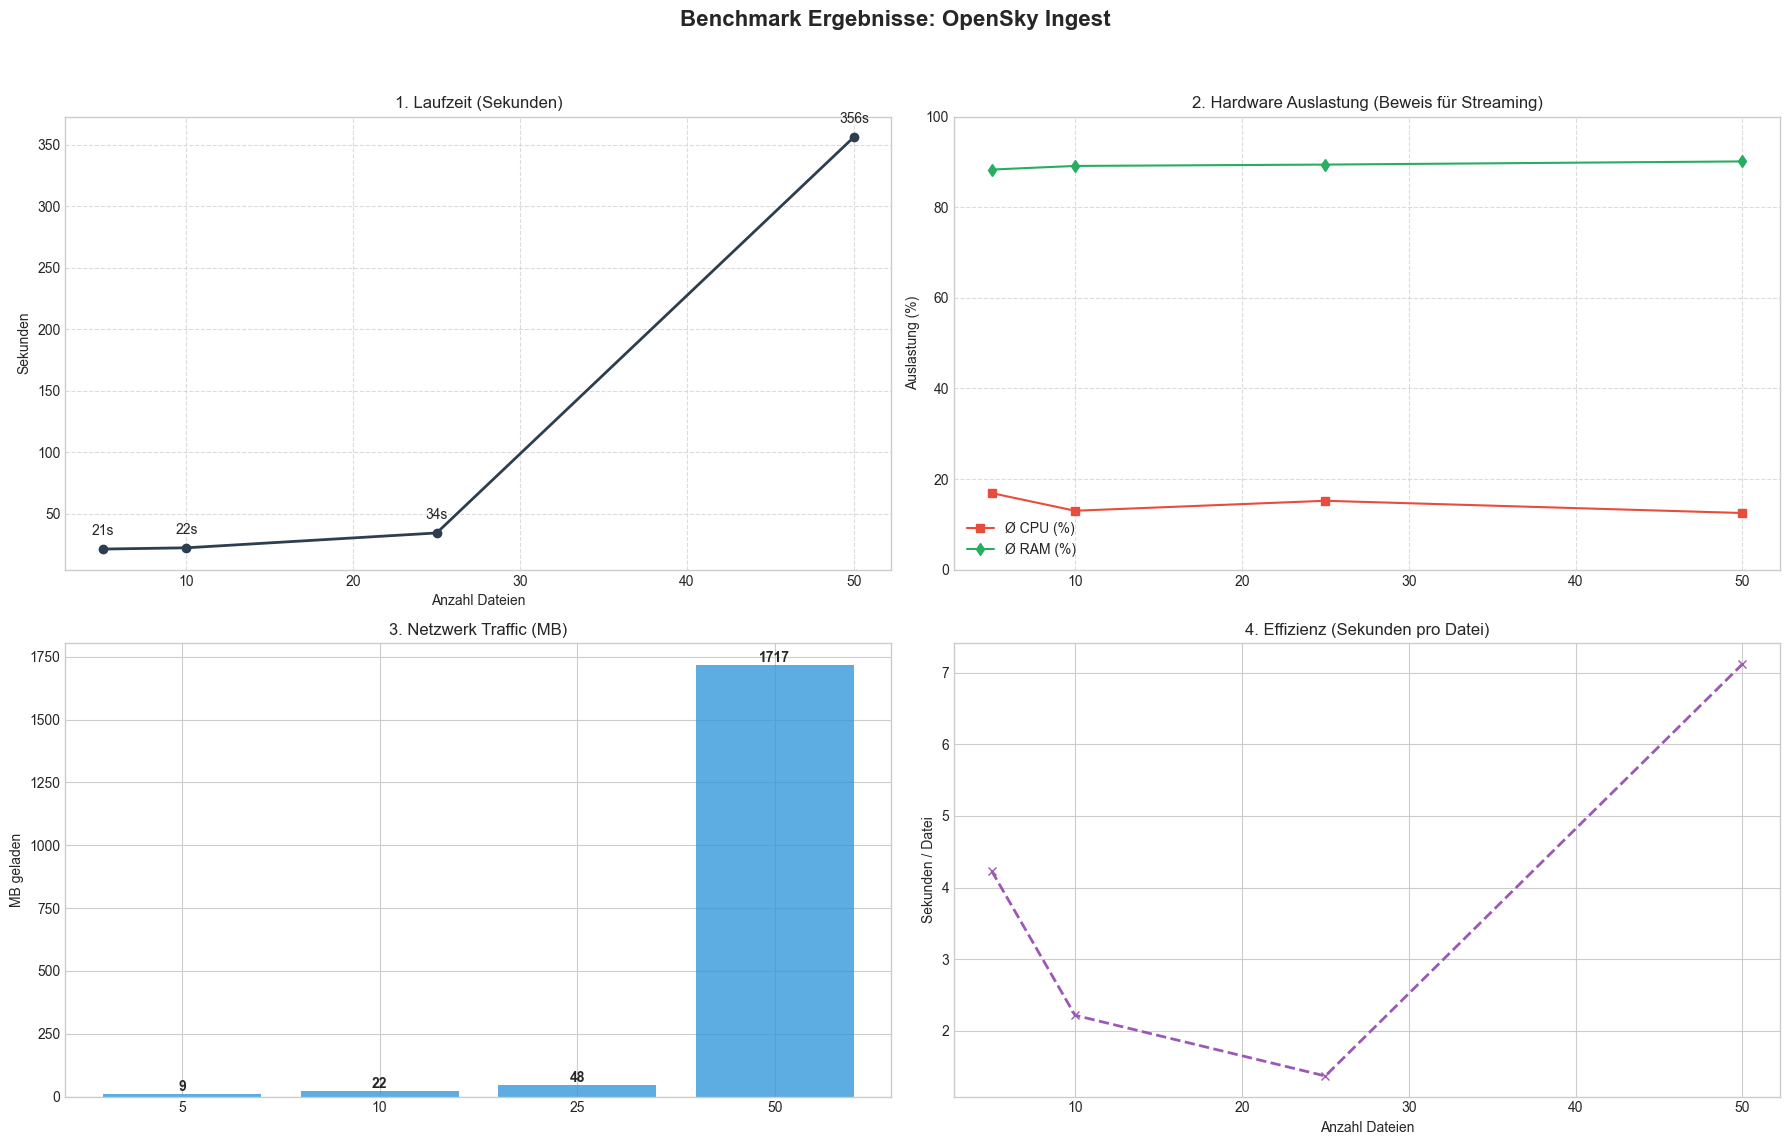

--- ZUSAMMENFASSUNG ---
 files_count  duration_sec  avg_cpu  avg_ram  net_mb  disk_mb
           5         21.17     16.9     88.3    9.25     2.86
          10         22.18     13.0     89.1   22.07     2.57
          25         34.26     15.2     89.4   47.83     2.56
          50        356.00     12.5     90.1 1717.25   306.25


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

print(">>> Start: Detaillierte System-Analyse")

# WICHTIG: Pfad dynamisch aus der Config holen (wie im Schritt davor)
# Falls PipelineConfig nicht verfügbar ist, Fallback auf lokalen Pfad
try:
    csv_file = PipelineConfig.METRICS_FILE.replace(".json", "_history.csv")
except NameError:
    csv_file = "benchmark_history.csv"

if os.path.exists(csv_file):
    # Daten laden und sortieren
    df = pd.read_csv(csv_file)
    df = df.sort_values("files_count")

    # Dubletten entfernen (falls du den Benchmark mehrfach hast laufen lassen)
    df = df.drop_duplicates(subset=['files_count'], keep='last')

    # Setup: 2x2 Grid
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Benchmark Ergebnisse: OpenSky Ingest', fontsize=16, fontweight='bold')

    # --- GRAPH 1: DAUER ---
    ax1 = axes[0, 0]
    ax1.plot(df['files_count'], df['duration_sec'], marker='o', color='#2c3e50', linewidth=2, label='Dauer (s)')
    for i, val in enumerate(df['duration_sec']):
        ax1.annotate(f"{val:.0f}s", (df['files_count'].iloc[i], val), xytext=(0, 10), textcoords='offset points', ha='center')
    ax1.set_title("1. Laufzeit (Sekunden)")
    ax1.set_xlabel("Anzahl Dateien")
    ax1.set_ylabel("Sekunden")
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- GRAPH 2: CPU & RAM ---
    ax2 = axes[0, 1]
    ax2.plot(df['files_count'], df['avg_cpu'], marker='s', color='#e74c3c', label='Ø CPU (%)')
    ax2.plot(df['files_count'], df['avg_ram'], marker='d', color='#27ae60', label='Ø RAM (%)')
    ax2.set_title("2. Hardware Auslastung (Beweis für Streaming)")
    ax2.set_ylim(0, 100)
    ax2.set_ylabel("Auslastung (%)")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    # --- GRAPH 3: NETZWERK VOLUMEN ---
    ax3 = axes[1, 0]
    bars = ax3.bar(df['files_count'].astype(str), df['net_mb'], color='#3498db', alpha=0.8)
    ax3.set_title("3. Netzwerk Traffic (MB)")
    ax3.set_ylabel("MB geladen")
    # Werte auf Balken
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

    # --- GRAPH 4: EFFIZIENZ (Sekunden pro Datei) ---
    ax4 = axes[1, 1]
    sec_per_file = df['duration_sec'] / df['files_count']
    ax4.plot(df['files_count'], sec_per_file, marker='x', color='#9b59b6', linestyle='--', linewidth=2)
    ax4.set_title("4. Effizienz (Sekunden pro Datei)")
    ax4.set_ylabel("Sekunden / Datei")
    ax4.set_xlabel("Anzahl Dateien")
    ax4.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("--- ZUSAMMENFASSUNG ---")
    print(df.to_string(index=False))

else:
    print(f"❌ Keine Benchmark-Daten gefunden unter: {csv_file}")
    print("Bitte führen Sie Schritt 4 (Benchmark) zuerst aus.")